In [1]:
import numpy
import itertools
from matplotlib import pyplot
import scipy.sparse
import scipy.special
from tqdm.notebook import tqdm
import functools

In [2]:
import qutip as qt

In [3]:
def gen_pairings(n, v=None):
    if v is None:
        v = list(range(n))
    if len(v) == 0:
        yield []
    else:
        a = v[0]
        for b in v[1:]:
            subv = v.copy()
            subv.remove(a)
            subv.remove(b)
            for subgen in gen_pairings(n,v=subv):
                yield [a,b] + subgen

def make_perms(n):
    return itertools.permutations(numpy.arange(n))

def make_canonical_perm(perm):
    ll = []
    for i in range(len(perm)//2):
        ll.append(min(perm[2*i], perm[2*i+1]))
        ll.append(max(perm[2*i], perm[2*i+1]))
    return tuple(ll)
    
def make_pairing_perms(n):
    return set(map(make_canonical_perm, make_perms(n)))

def make_mat_from_perm(perm):
    n = len(perm)
    D = 2**n
    mat = numpy.zeros((D,D))
    for i in range(D):
        localstate = bin(i)[2:].zfill(n)
        newlocal = ''.join(permutate_by_perm(perm, localstate))
        newindex = int(newlocal,2)        
        mat[newindex,i] = 1
    return scipy.sparse.csc_matrix(mat)
        
def get_local_state(index, n):
    state = []
    for _ in range(n):
        state.append(index % 2)
        index >>= 1
    return tuple(reversed(state))

def get_index_from_state(state):
    state = list(state)
    index = 0
    for i in state:
        index <<= 1
        index += i
    return index

def permutate_by_perm(perm, localstate):
    return tuple(localstate[i] for i in perm)

def dagger(x):
    return numpy.conjugate(x.T)


def yield_from_until(list_of_things, count=0, join_fn=None):
    if join_fn is None:
        join_fn = lambda a,b: a+b
    if count == 0:
        yield from list_of_things
    else:
        for a in yield_from_until(list_of_things, count=count-1, join_fn=join_fn):
            for b in list_of_things:
                yield join_fn(a,b)

In [4]:
make_mat_from_perm((1,0)).todense()

matrix([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])

How to invert the channel:

Note that the inverse channel is self adjoint and therefore
$$\langle O \rangle = \mathbb{E}\left\{ \text{Tr}[O M^{-1}(U^\dagger |b\rangle\langle b| U)]\right\} = \mathbb{E}\left\{ \text{Tr}[M^{-1}(O) U^\dagger |b\rangle\langle b| U]\right\}$$

Decompose $O = \sum_{s} c_s O_s$ with $s$ the support string, therefore $O_s = \bigotimes_i P_i$ with $P_i \ne \mathbb{1}$. 
Let $M^{-1}_s$ be the partial inverse for qubits $s$.

$$\langle O \rangle = \mathbb{E}\left\{ \sum_s c_s \text{Tr}[M^{-1}_s(O_s) U^\dagger |b\rangle\langle b| U]\right\}$$

Since $M^{-1}_s$ is acting on an operator with no $\mathbb{1}$ in it it's diagonal.

We start by making a table of the permutation and clifford gate used

All clifford group elements can be contructed:

$$\mathcal{C} = \{ \omega^{i} E^{j} X^{k} S^{l} ~:~ i\in range(8),~j\in range(2),~k\in range(3),~l\in range(4) \}$$

with $\omega = e^{\frac{2\pi i}{8}}$ and $E = \omega^3 H S^3$

We use a package that does this for is, then just transplant the clifford into the 2x2 central block of the number conserving 2-body unitaries.

In [5]:
cliffords = list(qt.qubit_clifford_group())

/var/folders/xx/cyn56y8j4l198w4cbbcv3pp80000gn/T/ipykernel_66138/633097405.py:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  cliffords = list(qt.qubit_clifford_group())


In [6]:
def f(x):
    y = numpy.eye(4, dtype=numpy.complex128)
    y[1:3,1:3] = x
    return y
mats = {i:m.__array__() for i,m in enumerate(cliffords)}
nmats = {
    k: f(v) for k,v in mats.items()
}
len(nmats)

24

In [7]:
def kron_helper(*args):
    a = args[0]
    for c in args[1:]:
        a = scipy.sparse.kron(a, c)
    return a

def gen_measurements(N, pair_mat_names, true_rho, name_to_mat_fn, iters=1000):
    for i in range(iters):
        perm = numpy.random.permutation(N)
        permmat = make_mat_from_perm(perm)
        channel_mat_names = numpy.random.choice(pair_mat_names, size=N//2)
        channel_mats = [scipy.sparse.csr_matrix(name_to_mat_fn(mat_name)) 
                        for mat_name in channel_mat_names]
        channel = kron_helper(*channel_mats) @ permmat
        channel_rho = channel @ true_rho @ channel.conjugate().T
        diag = numpy.diag(channel_rho)
        measurement = numpy.random.choice(numpy.arange(len(diag)), 1, p=diag.real)
        yield (perm, channel_mat_names, measurement[0])

In [8]:
# (01 + 10)00

zz = numpy.array([[0,1,1,0]])/numpy.sqrt(2)

zz = numpy.kron(zz, numpy.array([1,0,0,0]))
rho = zz.T @ zz
gen_meas = list(gen_measurements(4, list(nmats.keys()), rho, lambda x: nmats[x], iters=1000))

In [9]:
ops = {
    'I': numpy.eye(2),
    'Z': numpy.array([[1,0],[0,-1]]),
    '+': numpy.array([[0,1],[0,0]]),
    '-': numpy.array([[0,0],[1,0]]),
}
# basis = {
#     k: numpy.kron(ops[k[0]], ops[k[1]]) 
#     for k in ['II', 'ZZ', '+-', '-+', 'IZ', 'ZI']
# }

class Operator:
    def __init__(self, coefs, pauli_strings, use_ops=None):
        if use_ops is None:
            self.ops = ops.copy()
        else:
            self.ops = use_ops
        self.coefs = coefs
        self.pauli_strings = pauli_strings
        self.N = max(map(lambda x: len(x), self.pauli_strings))
    def make_mat(self, indices=None):
        if indices is None:
            indices = numpy.arange(self.N)
        acc = None
        for c,ps in zip(self.coefs, self.pauli_strings):
            paulis = (scipy.sparse.csr_matrix(self.ops[ps[i]]) for i in indices)
            mat = kron_helper(*paulis)
            if acc is None:
                acc = c*mat
            else:
                acc += c * mat
        return acc
    def expectation(self, rho):
        mat = self.make_mat()
        return (mat @ rho).trace()
    def coefs_and_strings(self):
        for c,p in zip(self.coefs, self.pauli_strings):
            yield (c,p)

In [10]:
op = Operator([1.0], ['ZZII'])

In [11]:
op.expectation(rho)

-0.9999999999999998

In [12]:
clifford_op = Operator([1.0], [[2]], use_ops=nmats)
clifford_op.make_mat().todense()

matrix([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [13]:
def channel_weight(pauli_string):
    L = len(pauli_string)
    counts = {k: pauli_string.count(k) for k in ops.keys()}
    if counts['+'] != counts['-']:
        return 0
    if counts['Z'] > 0 and counts['I'] > 0:
        raise NotImplementedError()
    else:
        if counts['+'] == counts['-'] == 0:
            return 1.0
        # Mix of +- and (I or Z)
        pm = 2*counts['+']
        prefactor = (1.0/3.0)**counts['+']
        places_for_pluses = scipy.special.factorial2(L)/scipy.special.factorial2(L-2*counts['+'])
        places_for_minuses = scipy.special.factorial(counts['-'])
        places_for_rest = scipy.special.factorial(L-pm)
        return prefactor * (places_for_pluses * places_for_minuses * places_for_rest / scipy.special.factorial(L))

In [14]:
channel_weight('+-+-+-')

0.014814814814814812

In [15]:
1/channel_weight('+-+-+-')

67.50000000000001

In [16]:
def filter_measurements(measurements, indices):
    for perm, mats, mes in measurements:
        all_true = True
        for i in range(len(perm)//2):
            sia = perm[2*i]
            sib = perm[2*i+1]
            sia_in = sia in indices 
            sib_in = sib in indices
            if sia_in != sib_in:
                all_true = False
                break
        if all_true:
            yield perm, mats, mes

def estimate_op(op, measurements, verbose=False):
    acc = 0.0
    for c, ps in op.coefs_and_strings():
        indices = [i for i in range(len(ps)) if ps[i] != 'I']
        indices_lookup = {v:k for k,v in enumerate(indices)}
        index_set = set(indices)
        substring = "".join([ps[i] for i in indices])
        cw = channel_weight(substring)
        if cw == 0.0:
            continue
        i = 0
        string_acc = 0.0
        for perm, mats, meas in filter_measurements(measurements, index_set):
            i += 1
            measbits = bin(meas)[2:].zfill(len(perm))
            if verbose:                
                permuted_string = ''.join(ps[i] for i in perm_inv)
                print(permuted_string, measbits)
            sub_acc = 1.0
            for pair_index in range(len(perm)//2):
                clifford_mat = mats[pair_index]
                pauli_a = ps[perm[2*pair_index]]
                pauli_b = ps[perm[2*pair_index+1]]
        
                # Assert not Z/I mixing
                assert (pauli_a == 'I') == (pauli_b == 'I')
                # Calculate <b(2i) b(2i+1)| C_i P_(s(2i)) P_(s(2i+1)) C_i^\dagger | b(2i) b(2i+1) >
                subop = Operator([1.0], [pauli_a + pauli_b]).make_mat()
                uppu = nmats[clifford_mat] @ subop @ dagger(nmats[clifford_mat])

                bita = measbits[2*pair_index]
                bitb = measbits[2*pair_index+1]
                submeas = int(bita + bitb, 2)
                braket = uppu[submeas, submeas]
                if verbose:
                    print("Calculating: <{0}|({1})({2}{3})({1})^(-1)|{0}> \t = {4}".format(bita+bitb,clifford_mat, pauli_a, pauli_b, braket))
                
                if pauli_a == 'I' and pauli_b == 'I':
                    assert numpy.allclose(braket, 1.0)
                sub_acc *= braket
            string_acc += sub_acc/cw
        acc += c * string_acc / float(i)
    return acc

Recall $$\rho = (|0100\rangle + |1000\rangle)(\langle0100| + \langle1000|))$$

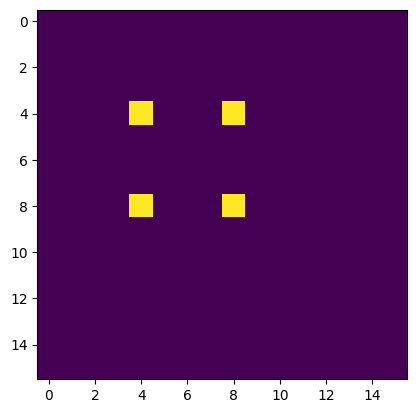

In [17]:
pyplot.imshow(rho)
pyplot.show()

In [18]:
op = Operator([1.0], ['ZZII'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(-0.9999999999999999+0j) -0.9999999999999998


In [19]:
op = Operator([1.0], ['ZIZI'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(0.047337278106508875-2.023935846882681e-33j) 0.0


In [20]:
op = Operator([1.0], ['+-II'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(0.5230547550432275+0.0043227665706051825j) 0.4999999999999999


In [21]:
op = Operator([0.5, 0.5], ['ZZII', 'ZIZI'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(-0.4763313609467455-1.0119679234413405e-33j) -0.4999999999999999


In [22]:
op = Operator([1.0], ['-+ZZ'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(0.5444999999999999-0.004500000000000001j) 0.4999999999999999


In [23]:
op = Operator([1.0], ['+Z-Z'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(-0.05399999999999999-0.009000000000000001j) 0.0


In [24]:
op = Operator([1.0], ['++--'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

0j 0.0


In [25]:
op = Operator([1.0], ['ZZZZ'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(-1-1.2572470676959877e-33j) -0.9999999999999998


# Test against new lib

In [26]:
import shadow_reconstruction


def gen_cliffords():
    yield from qt.qubit_clifford_group()


def get_num_cons_cliffords():
    def f(x):
        y = numpy.eye(4, dtype=numpy.complex128)
        y[1:3, 1:3] = x
        return y
    return {
        k: f(v.__array__()) for k, v in enumerate(gen_cliffords())
    }
cliffords = numpy.array(list(get_num_cons_cliffords().values()))

/var/folders/xx/cyn56y8j4l198w4cbbcv3pp80000gn/T/ipykernel_66138/3929011593.py:5: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  yield from qt.qubit_clifford_group()


In [27]:
recon = shadow_reconstruction.Reconstruction(4, ops=cliffords)

In [28]:
samples = shadow_reconstruction.Samples()

for (perm, mats, meas) in gen_meas:
    sample = shadow_reconstruction.Sample(mats, perm, meas)
    samples.add_sample(sample)

In [29]:
recon.estimate_operator_string('+-II', samples)

(0.5230547550432275-0.004322766570605189j)

In [30]:
recon.estimate_operator_string('+II-', samples)

(0.04285714285714285-0.014285714285714282j)

Now slightly more nontrivial

In [31]:
L = 4
zz = numpy.zeros((1, 1 << L))
zz[0, 0b0001] = 1.
zz[0, 0b1000] = 1.
zz /= numpy.linalg.norm(zz)
rho = zz.T @ zz

gen_meas = list(gen_measurements(L, list(nmats.keys()), rho, lambda x: nmats[x], iters=10000))

In [32]:
samples = shadow_reconstruction.Samples()

for (perm, mats, meas) in gen_meas:
    sample = shadow_reconstruction.Sample(mats, perm, meas)
    samples.add_sample(sample)

In [33]:
opstr = 'ZIIZ'
estimate = recon.estimate_operator_string(opstr, samples)
print(estimate, Operator([1.], [opstr]).expectation(rho))

opstr = 'IIZZ'
estimate = recon.estimate_operator_string(opstr, samples)
print(estimate, Operator([1.], [opstr]).expectation(rho))

(-1+0j) -0.9999999999999998
(0.014692653673163452+0j) 0.0


In [34]:
opstr = '-II+'
estimate = recon.estimate_operator_string(opstr, samples)
print(estimate, Operator([1.], [opstr]).expectation(rho))

(0.4904619970193739-0.013412816691505215j) 0.4999999999999999


# Check sims

In [35]:
exp = shadow_reconstruction.Experiment(4, ops=cliffords)

rhod = shadow_reconstruction.DensityMatrix.from_dense(rho.astype(numpy.complex128))
samples = exp.sample(rhod, 1000)
gen_meas = []
for si in range(samples.num_samples()):
    sample = samples.get_sample(si)
    mats = sample.get_gates()
    perm = sample.get_perm()
    meas = sample.get_measurement()
    
    gen_meas.append((perm, mats, meas))

In [36]:
op = Operator([1.], ['ZIIZ'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(-1+1.0937112022210332e-33j) -0.9999999999999998


In [37]:
op = Operator([1.], ['-II+'])
estimate = estimate_op(op, gen_meas)
print(estimate, op.expectation(rho))

(0.4774647887323943-0.02535211267605634j) 0.4999999999999999


# Check perms

In [38]:
for perm in make_perms(4):
    assert (shadow_reconstruction.Experiment.make_perm_mat(perm).todense() == make_mat_from_perm(perm)).all(), "Failed for "+str(perm)

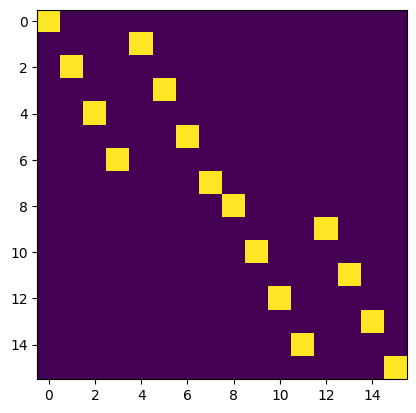

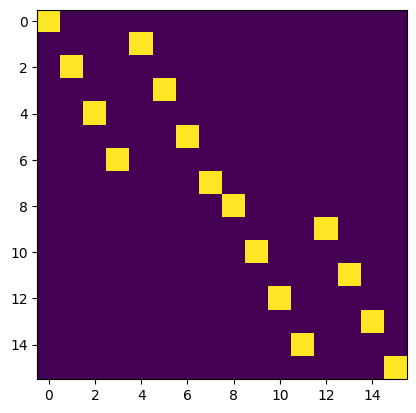

In [39]:
pyplot.imshow(shadow_reconstruction.Experiment.make_perm_mat([0,2,3,1]).todense())
pyplot.show()

pyplot.imshow(make_mat_from_perm([0,2,3,1]).todense())
pyplot.show()